# Model training

In [2]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report, precision_score, recall_score, f1_score 
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [3]:
# Read images from a directory, convert to grayscale and resize
def read_images_from_dir(directory, size=(64, 64)): #NEED TO FIX THE RESIZE AGAIN!!! 
    images = []
    labels = []
    for folder in ['Malignant', 'Benign']:
        folder_path = os.path.join(directory, folder)
        for filename in os.listdir(folder_path):
            if filename.endswith(".jpg"):  # You can also add other formats if needed
                img_path = os.path.join(folder_path, filename)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                img_resized = cv2.resize(img, size)
                images.append(img_resized.ravel())  # Convert 2D image to 1D
                labels.append(folder)
    return np.array(images), np.array(labels)

In [7]:
# Encode labels
encoder = LabelEncoder()
# Read training data
X_train, y_train = read_images_from_dir("Brain_Tumor/Train")
y_train = encoder.fit_transform(y_train)  # Fit and transform the training labels

In [8]:
# Apply PCA
n_components = 150 
pca = PCA(n_components=n_components, whiten=True).fit(X_train)
X_train_pca = pca.transform(X_train) # same as fit.transform()

In [9]:
# Read test data
X_test, y_test = read_images_from_dir('Brain_Tumor/Test')
y_test = encoder.transform(y_test)  # Use the encoder fitted on training data to transform test labels
X_test_pca = pca.transform(X_test)  # Use the same PCA object to transform test data

## 1. KNN

In [27]:
cv = StratifiedKFold(5, random_state=1, shuffle=True)
knn = KNeighborsClassifier()

params = {
    "weights": ["uniform", "distance"],
    "n_neighbors": np.arange(1, 16, 1),
    "metric": ["cityblock", "euclidean", "cosine", "l1", "l2", "manhattan", "nan_euclidean"]
}

clf = GridSearchCV(estimator=knn, param_grid=params, scoring="f1", cv=cv, n_jobs=-1) #cuz im using alr balanced data, so use F1 rather than f1 weighted
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

knn_results = pd.DataFrame(clf.cv_results_).drop(["mean_fit_time", "std_fit_time", "mean_score_time", "std_score_time", "params"], axis=1).rename(columns={"param_metric": "metric", "param_n_neighbors": "n_neighbors", "param_weights": "weights"})
knn_results.to_csv(f"Results/knn_results.csv")

Accuracy: 0.7659574468085106
F1_score 0.8307692307692308
Micro F1_score: 0.7659574468085105
Weighted F1_score: 0.7592527795022292
              precision    recall  f1-score   support

           0       0.69      0.56      0.62        16
           1       0.79      0.87      0.83        31

    accuracy                           0.77        47
   macro avg       0.74      0.72      0.73        47
weighted avg       0.76      0.77      0.76        47

----Top 5 models----


,metric,n_neighbors,weights,mean_test_score,std_test_score,rank_test_score
0,cosine,4,distance,0.886924,0.029471,1
1,cosine,14,distance,0.883662,0.025849,2
2,cosine,5,distance,0.882007,0.036060,3
3,cosine,15,distance,0.877735,0.040190,4
4,cosine,3,distance,0.876121,0.041737,5



----Confusion Matrix----


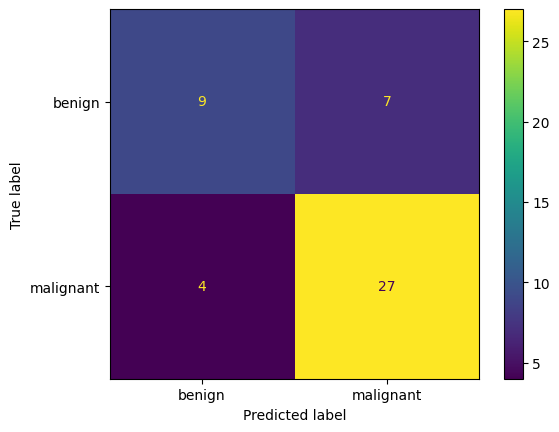

In [28]:
print("Accuracy:", accuracy_score(y_test, y_pred))

f1 = f1_score(y_test, y_pred)
print("F1_score", f1)
print("Micro F1_score:", f1_score(y_test, y_pred, average="micro"))
print("Weighted F1_score:", f1_score(y_test, y_pred, average="weighted"))

print(classification_report(y_test, y_pred))

print("----Top 5 models----")
display(knn_results.sort_values("rank_test_score").iloc[[0, 1, 2, 3, 4], [0, 1, 2, 8, 9, 10]].reset_index(drop=True))

print("\n----Confusion Matrix----")
cm = confusion_matrix(y_test, y_pred)

labels = ["benign", "malignant"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

disp.plot()
plt.show()

## 2. Decision Tree (DT)

In [29]:
from sklearn.tree import DecisionTreeClassifier

In [30]:
cv = StratifiedKFold(5, random_state=1, shuffle=True)
dt = DecisionTreeClassifier()

params = {
    "max_depth" : np.arange(5, 15, 1),
    "criterion": ["gini", "entropy", "log_loss"],
    "max_features":  ["sqrt", "log2", None]
}

clf = GridSearchCV(estimator=dt, param_grid=params, scoring="f1", cv=cv, n_jobs=-1) # The best model is chosen based on the metric of the refit param. Can be set to any metric listed in the "scoring" list above
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

dt_results = pd.DataFrame(clf.cv_results_).drop(["mean_fit_time", "std_fit_time", "mean_score_time", "std_score_time", "params"], axis=1).rename(columns={"param_max_depth": "max_depth", "param_min_samples_split": "min_samples_split", "param_min_samples_leaf": "min_samples_leaf", "param_max_features": "max_features"})
dt_results.to_csv(f"Results/dt_results.csv")

Accuracy: 0.723404255319149
F1_score 0.8115942028985507
Micro F1_score: 0.723404255319149
Weighted F1_score: 0.6987110699969163
              precision    recall  f1-score   support

           0       0.67      0.38      0.48        16
           1       0.74      0.90      0.81        31

    accuracy                           0.72        47
   macro avg       0.70      0.64      0.65        47
weighted avg       0.71      0.72      0.70        47

----Top 5 models----


,param_criterion,max_depth,max_features,mean_test_score,std_test_score,rank_test_score
0,entropy,10,log2,0.843228,0.030226,1
1,log_loss,11,sqrt,0.843214,0.068978,2
2,log_loss,12,log2,0.834637,0.029116,3
3,log_loss,9,None,0.833169,0.043035,4
4,log_loss,14,None,0.831507,0.035637,5



----Confusion Matrix----


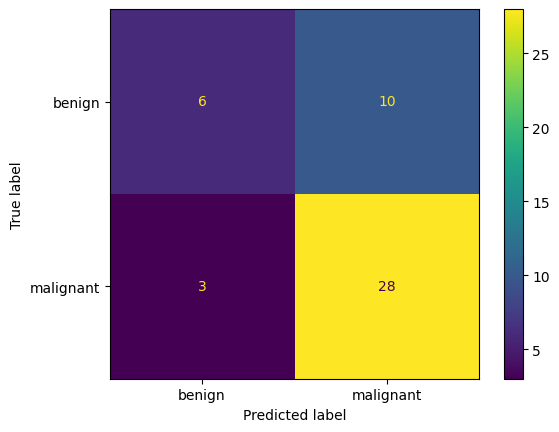

In [31]:
print("Accuracy:", accuracy_score(y_test, y_pred))

f1 = f1_score(y_test, y_pred)
print("F1_score", f1)
print("Micro F1_score:", f1_score(y_test, y_pred, average="micro"))
print("Weighted F1_score:", f1_score(y_test, y_pred, average="weighted"))

print(classification_report(y_test, y_pred))


print("----Top 5 models----")
display(dt_results.sort_values("rank_test_score").iloc[[0, 1, 2, 3, 4], [0, 1, 2, 8, 9, 10]].reset_index(drop=True))

print("\n----Confusion Matrix----")
cm = confusion_matrix(y_test, y_pred)

labels = ["benign", "malignant"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

disp.plot()
plt.show()

## 3. Naive Bayes 

In [32]:
from sklearn.naive_bayes import GaussianNB

In [33]:
cv = StratifiedKFold(5, random_state=1, shuffle=True)
clf = GaussianNB()

# clf = GridSearchCV(estimator=dt, param_grid=params, scoring="f1", cv=cv, n_jobs=-1) # The best model is chosen based on the metric of the refit param. Can be set to any metric listed in the "scoring" list above
#NB dont need hyperparameter tuning! 
clf.fit(X_train, y_train)
scores = cross_val_score(clf, X_train, y_train, cv=cv)

y_pred = clf.predict(X_test)


Cross-validated scores: [0.67567568 0.64864865 0.7027027  0.59459459 0.69444444]
Mean accuracy: 0.6632132132132134
Standard deviation of accuracy: 0.03901477647525414
Accuracy: 0.6595744680851063
F1_score 0.6799999999999999
Micro F1_score: 0.6595744680851063
Weighted F1_score: 0.6651450676982591
              precision    recall  f1-score   support

           0       0.50      0.88      0.64        16
           1       0.89      0.55      0.68        31

    accuracy                           0.66        47
   macro avg       0.70      0.71      0.66        47
weighted avg       0.76      0.66      0.67        47

----Model evaluation----


,mean_accuracy_score,weighted_precision_score,weighted_recall_score,weighted_f1_score
0,0.760358,0.659574,0.665145,0.659574



----Confusion Matrix----


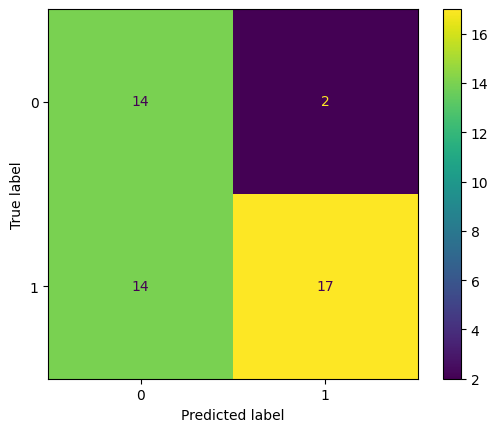

In [34]:
# Print the cross-validated scores
print("Cross-validated scores:", scores)

# Calculate and print the mean accuracy and its standard deviation
print("Mean accuracy:", scores.mean())
print("Standard deviation of accuracy:", scores.std())

print("Accuracy:", accuracy_score(y_test, y_pred))

f1 = f1_score(y_test, y_pred)
print("F1_score", f1)
print("Micro F1_score:", f1_score(y_test, y_pred, average="micro"))
print("Weighted F1_score:", f1_score(y_test, y_pred, average="weighted"))

print(classification_report(y_test, y_pred))


# NEED TO CHANGE WEIGHTED OR NOT? CHECK DATASET. Weighted is for unbalanced
results = []
results.append([
    precision_score(y_test, y_pred, average='weighted'),
    recall_score(y_test, y_pred, average='weighted'), 
    f1_score(y_test, y_pred, average='weighted'), 
    clf.score(X_test, y_test)
])

print("----Model evaluation----")
display(pd.DataFrame(results, columns=["mean_accuracy_score", "weighted_precision_score", "weighted_recall_score", "weighted_f1_score"]))

print("\n----Confusion Matrix----")
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

## 4. Support Vector Machine (SVM)

In [35]:
from sklearn.svm import SVC

In [36]:
## Normalize to speed up process
def normalize_image(image):
    image_float = image.astype(float)
    min_val = np.min(image_float.ravel())
    max_val = np.max(image_float.ravel())
    normalized = (image_float - min_val) / (max_val - min_val)
    return normalized

In [37]:
# Repeat same process but w normalized images now

# Read and normalize training data
X_train, y_train = read_images_from_dir("Brain_Tumor/Train")
X_train = np.array([normalize_image(img) for img in X_train])
y_train = encoder.fit_transform(y_train)
# Apply PCA
n_components = 150
pca = PCA(n_components=n_components, whiten=True).fit(X_train)
X_train_pca = pca.transform(X_train)

In [38]:
# Read and normalize test data
X_test, y_test = read_images_from_dir('Brain_Tumor/Test')
X_test = np.array([normalize_image(img) for img in X_test])
y_test = encoder.transform(y_test)
X_test_pca = pca.transform(X_test)

In [39]:
# SCALE the PCA data (optional but can be beneficial for SVM)
scaler = StandardScaler().fit(X_train_pca)
X_train_pca = scaler.transform(X_train_pca)
X_test_pca = scaler.transform(X_test_pca)
#After PCA, data is scaled using StandardScaler as SVM often performs better when the input data is centered and has unit variance.

In [40]:
# SVM with Grid Search
params = {
    "C": [0.1, 1, 10, 100],
    "gamma": ["scale", 0.1, 1, 10],
    "kernel": ["linear", "rbf"]
}

cv = StratifiedKFold(5, random_state=1, shuffle=True)
svm = SVC()

clf = GridSearchCV(estimator=svm, param_grid=params, scoring="f1", cv=cv, n_jobs=-1)
clf.fit(X_train_pca, y_train)

y_pred = clf.predict(X_test_pca)

svm_results = pd.DataFrame(clf.cv_results_).drop(["mean_fit_time", "std_fit_time", "mean_score_time", "std_score_time", "params"], axis=1)
svm_results.to_csv(f"Results/svm_results.csv")

Accuracy: 0.8085106382978723
F1_score 0.8695652173913043
Micro F1_score: 0.8085106382978723
Weighted F1_score: 0.7914153561517113
              precision    recall  f1-score   support

           0       0.89      0.50      0.64        16
           1       0.79      0.97      0.87        31

    accuracy                           0.81        47
   macro avg       0.84      0.73      0.75        47
weighted avg       0.82      0.81      0.79        47

----Top 5 models----


,param_C,param_gamma,param_kernel,mean_test_score,std_test_score,rank_test_score
0,100,scale,rbf,0.855112,0.031559,1
1,10,scale,rbf,0.855112,0.031559,1
2,100,1,rbf,0.851865,0.026223,3
3,100,0.1,rbf,0.851865,0.026223,3
4,10,1,rbf,0.851865,0.026223,3



----Confusion Matrix----


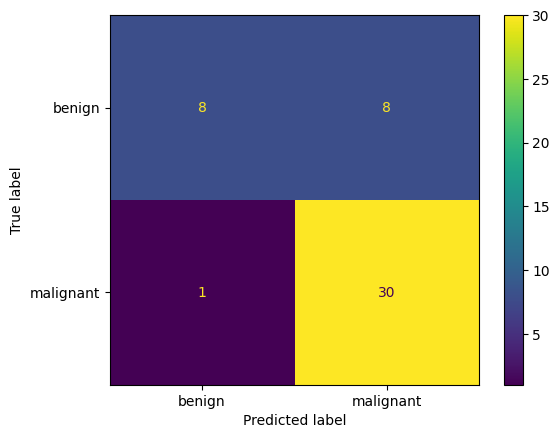

In [41]:
print("Accuracy:", accuracy_score(y_test, y_pred))

f1 = f1_score(y_test, y_pred)
print("F1_score", f1)
print("Micro F1_score:", f1_score(y_test, y_pred, average="micro"))
print("Weighted F1_score:", f1_score(y_test, y_pred, average="weighted"))

print(classification_report(y_test, y_pred))

print("----Top 5 models----")
display(svm_results.sort_values("rank_test_score").iloc[[0, 1, 2, 3, 4], [0, 1, 2, 8, 9, 10]].reset_index(drop=True))

print("\n----Confusion Matrix----")
cm = confusion_matrix(y_test, y_pred)
labels = ["benign", "malignant"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()